In [ ]:
import numpy as np

class FC:
    """
    Fully Connected Layer
    Parameters
    ----------
    n_nodes1 : int
        Number of nodes in the previous layer
    n_nodes2 : int
        Number of nodes in the next layer
    initializer : instance of weight initialization class
    optimizer : instance of optimizer class (e.g., SGD)
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.optimizer = optimizer
        
        # Initialize weights (W) and biases (B)
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)

    def forward(self, X):
        """
        Forward propagation through fully connected layer
        Parameters
        ----------
        X : ndarray of shape (batch_size, n_nodes1)
        Returns
        ----------
        A : ndarray of shape (batch_size, n_nodes2)
        """
        self.X = X  
        A = np.dot(X, self.W) + self.B
        return A

    def backward(self, dA):
        """
        Backward propagation
        Parameters
        ----------
        dA : ndarray of shape (batch_size, n_nodes2)
            Gradient from next layer
        Returns
        ----------
        dZ : ndarray of shape (batch_size, n_nodes1)
            Gradient to pass to previous layer
        """
        # Gradients
        self.dW = np.dot(self.X.T, dA)
        self.dB = np.sum(dA, axis=0)
        dZ = np.dot(dA, self.W.T)

        #weights
        self = self.optimizer.update(self)

        return dZ


In [2]:
class SimpleInitializer:
    """
    Simple initialization with Gaussian distribution
    Parameters
    ----------
    sigma : float
      Standard deviation of Gaussian distribution
    """
    def __init__(self, sigma):
        self.sigma = sigma

    def W(self, n_nodes1, n_nodes2):
        """
        Weight initialization
        Parameters
        ----------
        n_nodes1 : int
          Number of nodes in the previous layer
        n_nodes2 : int
          Number of nodes in the later layer
        Returns
        ----------
        W : ndarray of shape (n_nodes1, n_nodes2)
        """
        W = np.random.randn(n_nodes1, n_nodes2) * self.sigma
        return W

    def B(self, n_nodes2):
        """
        Bias initialization
        Parameters
        ----------
        n_nodes2 : int
          Number of nodes in the later layer
        Returns
        ----------
        B : ndarray of shape (n_nodes2,)
        """
        B = np.zeros(n_nodes2)
        return B


In [ ]:
class SGD:
    """
    Stochastic Gradient Descent (SGD)
    Parameters
    ----------
    lr : float
        Learning rate
    """
    def __init__(self, lr):
        self.lr = lr

    def update(self, layer):
        """
        Update weights and biases for a given layer
        Parameters
        ----------
        layer : instance of FC (Fully Connected Layer)
        Returns
        ----------
        layer : updated layer instance
        """
        #parameter update
        layer.W -= self.lr * layer.dW
        layer.B -= self.lr * layer.dB

        return layer


In [4]:
class ReLU:
    def forward(self, X):
        self.mask = (X <= 0)
        out = X.copy()
        out[self.mask] = 0
        return out

    def backward(self, dA):
        dA[self.mask] = 0
        return dA


class Sigmoid:
    def forward(self, X):
        self.out = 1 / (1 + np.exp(-X))
        return self.out

    def backward(self, dA):
        return dA * self.out * (1 - self.out)

class Tanh:
    def forward(self, X):
        self.out = np.tanh(X)
        return self.out

    def backward(self, dA):
        return dA * (1 - self.out ** 2)


class Softmax:
    def forward(self, X):
        X = X - np.max(X, axis=1, keepdims=True)  # for stability
        exp_X = np.exp(X)
        self.out = exp_X / np.sum(exp_X, axis=1, keepdims=True)
        return self.out

    def backward(self, dA, Y):
        """
        Y: one-hot true labels
        Returns gradient of loss w.r.t input to softmax
        """
        batch_size = Y.shape[0]
        return (self.out - Y) / batch_size


In [5]:
import numpy as np

class ReLU:
    def forward(self, X):
        """
        Apply ReLU activation function: f(x) = max(0, x)
        Save mask of where input is less than or equal to zero for backward.
        Parameters
        ----------
        X : ndarray, shape (batch_size, n_features)
        Returns
        -------
        out : ndarray, shape (batch_size, n_features)
        """
        self.mask = (X <= 0)
        out = X.copy()
        out[self.mask] = 0
        return out

    def backward(self, dA):
        """
        Backward pass for ReLU.
        Gradient only passes through where input was > 0.
        Parameters
        ----------
        dA : ndarray, shape (batch_size, n_features)
            Gradient from next layer
        Returns
        -------
        dZ : ndarray, shape (batch_size, n_features)
        """
        dA[self.mask] = 0
        return dA


In [6]:
import numpy as np

class XavierInitializer:
    """
    Xavier (Glorot) Initializer for sigmoid/tanh
    σ = 1 / sqrt(n)
    """
    def W(self, n_nodes1, n_nodes2):
        sigma = 1 / np.sqrt(n_nodes1)
        return np.random.randn(n_nodes1, n_nodes2) * sigma

    def B(self, n_nodes2):
        return np.zeros(n_nodes2)


class HeInitializer:
    """
    He Initializer for ReLU
    σ = sqrt(2 / n)
    """
    def W(self, n_nodes1, n_nodes2):
        sigma = np.sqrt(2 / n_nodes1)
        return np.random.randn(n_nodes1, n_nodes2) * sigma

    def B(self, n_nodes2):
        return np.zeros(n_nodes2)


In [ ]:
import numpy as np

class AdaGrad:
    """
    AdaGrad optimizer
    Parameters
    ----------
    lr : float
        Initial learning rate
    """
    def __init__(self, lr=0.01):
        self.lr = lr
        self.epsilon = 1e-7  # To avoid division by zero

    def update(self, layer):
        """
        Update weights and biases using AdaGrad
        Parameters
        ----------
        layer : instance of FC
        """
        # Initialize accumulators
        if not hasattr(layer, 'h_W'):
            layer.h_W = np.zeros_like(layer.W)
            layer.h_B = np.zeros_like(layer.B)

        # Accumulate squared gradients
        layer.h_W += layer.dW ** 2
        layer.h_B += layer.dB ** 2

        # Update with AdaGrad rule
        layer.W -= self.lr * layer.dW / (np.sqrt(layer.h_W) + self.epsilon)
        layer.B -= self.lr * layer.dB / (np.sqrt(layer.h_B) + self.epsilon)

        return layer


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class ScratchDeepNeuralNetworkClassifier:
    def __init__(self, n_epochs=10, batch_size=32, lr=0.01, sigma=0.01,
                 n_nodes_list=[64, 32], n_output=10,
                 initializer=None, optimizer=None,
                 activations=None, verbose=True):
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.lr = lr
        self.sigma = sigma
        self.n_nodes_list = n_nodes_list
        self.n_output = n_output
        self.initializer = initializer
        self.optimizer = optimizer
        self.activations = activations
        self.verbose = verbose

        self.layers = []
        self.loss_train = []
        self.loss_val = []

    def fit(self, X, y, X_val=None, y_val=None):
        self._build_network(X.shape[1], y.shape[1])

        for epoch in range(self.n_epochs):
            # Shuffle the dataset
            if isinstance(X, np.ndarray):
                X_array = X
                y_array = y
            else:
                #
                X_array = X.to_numpy()
                y_array = y.to_numpy()

            perm = np.random.permutation(len(X_array))
            X_shuffled = X_array[perm] 
            y_shuffled = y_array[perm]  

            epoch_loss = 0
            for i in range(0, len(X), self.batch_size):
                X_batch = X_shuffled[i:i+self.batch_size]
                y_batch = y_shuffled[i:i+self.batch_size]

                # Forward pass
                output = self._forward(X_batch)

                # Loss calculation
                loss = self._cross_entropy(output, y_batch)
                epoch_loss += loss

                # Backward pass
                self._backward(output, y_batch)

            self.loss_train.append(epoch_loss / (len(X) // self.batch_size))

            # Validation
            if X_val is not None and y_val is not None:
                val_output = self._forward(X_val)
                val_loss = self._cross_entropy(val_output, y_val)
                self.loss_val.append(val_loss)

            if self.verbose:
                print(f"Epoch {epoch+1}/{self.n_epochs}, Train Loss: {self.loss_train[-1]:.4f}" + 
                      (f", Val Loss: {self.loss_val[-1]:.4f}" if self.loss_val else ""))

        self._plot_learning_curve()

    def predict(self, X):
        probs = self._forward(X)
        return np.argmax(probs, axis=1)

    def _build_network(self, n_features, n_classes):
        self.layers = []
        layer_sizes = [n_features] + self.n_nodes_list + [n_classes]

        for i in range(len(layer_sizes)-1):
            fc = FC(layer_sizes[i], layer_sizes[i+1], self.initializer, self.optimizer)
            self.layers.append(fc)
            ####
            if i < len(self.n_nodes_list):
                self.layers.append(self.activations[i])
            else:
                self.layers.append(Softmax())

    def _forward(self, X):
        for layer in self.layers:
            X = layer.forward(X)
        return X

    def _backward(self, output, y_true):
        grad = self.layers[-1].backward(output, y_true)
        for layer in reversed(self.layers[:-1]):
            grad = layer.backward(grad)

    def _cross_entropy(self, y_pred, y_true):
        return -np.mean(np.sum(y_true * np.log(y_pred + 1e-7), axis=1))

    def _plot_learning_curve(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.loss_train, label='Train Loss')
        if self.loss_val:
            plt.plot(self.loss_val, label='Validation Loss')
        plt.title("Learning Curve")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(True)
        plt.show()


c:\Users\Admin\.pyenv\pyenv-win\versions\3.8.10\lib\site-packages\sklearn\datasets\_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
c:\Users\Admin\.pyenv\pyenv-win\versions\3.8.10\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(



Training 2 Layers (ReLU)...
Epoch 1/10, Train Loss: 0.9787, Val Loss: 0.5473, Train Acc: 0.8666, Val Acc: 0.8639
Epoch 2/10, Train Loss: 0.4590, Val Loss: 0.4180, Train Acc: 0.8910, Val Acc: 0.8886
Epoch 3/10, Train Loss: 0.3786, Val Loss: 0.3709, Train Acc: 0.9026, Val Acc: 0.8991
Epoch 4/10, Train Loss: 0.3410, Val Loss: 0.3422, Train Acc: 0.9089, Val Acc: 0.9059
Epoch 5/10, Train Loss: 0.3177, Val Loss: 0.3235, Train Acc: 0.9142, Val Acc: 0.9119
Epoch 6/10, Train Loss: 0.2989, Val Loss: 0.3088, Train Acc: 0.9172, Val Acc: 0.9154
Epoch 7/10, Train Loss: 0.2853, Val Loss: 0.2979, Train Acc: 0.9206, Val Acc: 0.9183
Epoch 8/10, Train Loss: 0.2730, Val Loss: 0.2903, Train Acc: 0.9235, Val Acc: 0.9200
Epoch 9/10, Train Loss: 0.2626, Val Loss: 0.2771, Train Acc: 0.9271, Val Acc: 0.9234
Epoch 10/10, Train Loss: 0.2529, Val Loss: 0.2694, Train Acc: 0.9294, Val Acc: 0.9256
2 Layers (ReLU) - Test Accuracy: 0.9261

Training 3 Layers (ReLU)...
Epoch 1/10, Train Loss: 0.9076, Val Loss: 0.4570, T

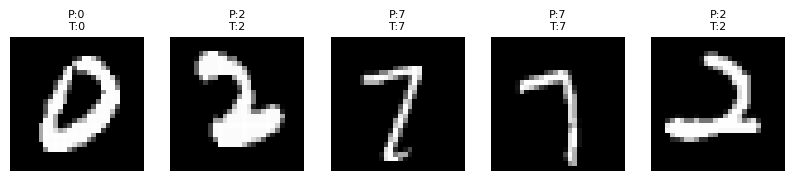

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

#activation functions
class ReLU:
    def __call__(self, x):
        return np.maximum(0, x)
    def gradient(self, x):
        return (x > 0).astype(float)

class Sigmoid:
    def __call__(self, x):
        return 1 / (1 + np.exp(-x))
    def gradient(self, x):
        s = self.__call__(x)
        return s * (1 - s)

class Tanh:
    def __call__(self, x):
        return np.tanh(x)
    def gradient(self, x):
        return 1 - np.tanh(x)**2

#initializers
class HeInitializer:
    def __call__(self, shape):
        fan_in = shape[0]
        return np.random.randn(*shape) * np.sqrt(2.0 / fan_in)

class XavierInitializer:
    def __call__(self, shape):
        fan_in, fan_out = shape[0], shape[1]
        limit = np.sqrt(6.0 / (fan_in + fan_out))
        return np.random.uniform(-limit, limit, size=shape)

#optimizer
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

# NN Implementation
class NeuralNetwork:
    def __init__(self, layers, activations, initializer=HeInitializer(), optimizer=SGD(), 
                 learning_rate=0.01, batch_size=32, epochs=10, verbose=True):
        self.layers = layers
        self.activations = activations
        self.initializer = initializer
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.verbose = verbose
        self.weights = []
        self.biases = []
        
    def initialize_parameters(self):
        self.weights = []
        self.biases = []
        for i in range(len(self.layers)-1):
            self.weights.append(self.initializer((self.layers[i], self.layers[i+1])))
            self.biases.append(np.zeros((1, self.layers[i+1])))
    
    def forward(self, X):
        self.cache = {'A0': X}
        A = X
        for i in range(len(self.weights)-1):
            Z = np.dot(A, self.weights[i]) + self.biases[i]
            A = self.activations[i](Z)
            self.cache[f'Z{i+1}'] = Z
            self.cache[f'A{i+1}'] = A
        
        # Output layer (softmax)
        Z = np.dot(A, self.weights[-1]) + self.biases[-1]
        A = self.softmax(Z)
        self.cache[f'Z{len(self.weights)}'] = Z
        self.cache[f'A{len(self.weights)}'] = A
        return A
    
    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)
    
    def compute_loss(self, y_true, y_pred):
        m = y_true.shape[0]
        return -np.sum(y_true * np.log(y_pred + 1e-10)) / m
    
    def backward(self, y_true):
        grads = {'weights': [], 'biases': []}
        m = y_true.shape[0]
        
        # Output layer gradient
        dZ = self.cache[f'A{len(self.weights)}'] - y_true
        grads['weights'].insert(0, np.dot(self.cache[f'A{len(self.weights)-1}'].T, dZ) / m)
        grads['biases'].insert(0, np.sum(dZ, axis=0, keepdims=True) / m)
        
        # Hidden layers gradients
        for i in reversed(range(len(self.weights)-1)):
            dA = np.dot(dZ, self.weights[i+1].T)
            dZ = dA * self.activations[i].gradient(self.cache[f'Z{i+1}'])
            grads['weights'].insert(0, np.dot(self.cache[f'A{i}'].T, dZ) / m)
            grads['biases'].insert(0, np.sum(dZ, axis=0, keepdims=True) / m)
        
        return grads
    
    def update_parameters(self, grads):
        for i in range(len(self.weights)):
            self.weights[i] -= self.learning_rate * grads['weights'][i]
            self.biases[i] -= self.learning_rate * grads['biases'][i]
    
    def fit(self, X, y, X_val=None, y_val=None):
        X = X.values if hasattr(X, 'values') else X
        y = y.values if hasattr(y, 'values') else y
        
        self.initialize_parameters()
        self.optimizer.lr = self.learning_rate
        
        history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
        
        for epoch in range(self.epochs):
            # Shuffle data
            perm = np.random.permutation(len(X))
            X_shuffled = X[perm]
            y_shuffled = y[perm]
            
            batch_losses = []
            for i in range(0, len(X), self.batch_size):
                X_batch = X_shuffled[i:i+self.batch_size]
                y_batch = y_shuffled[i:i+self.batch_size]
                
                # Forward pass
                y_pred = self.forward(X_batch)
                loss = self.compute_loss(y_batch, y_pred)
                batch_losses.append(loss)
                
                # Backward pass
                grads = self.backward(y_batch)
                
                # Update parameters
                self.update_parameters(grads)
            
            #metrics
            train_loss = np.mean(batch_losses)
            train_pred = np.argmax(self.forward(X), axis=1)
            train_acc = accuracy_score(np.argmax(y, axis=1), train_pred)
            
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            
            if X_val is not None:
                val_pred = self.forward(X_val)
                val_loss = self.compute_loss(y_val, val_pred)
                val_acc = accuracy_score(np.argmax(y_val, axis=1), np.argmax(val_pred, axis=1))
                history['val_loss'].append(val_loss)
                history['val_acc'].append(val_acc)
            
            if self.verbose:
                if X_val is not None:
                    print(f"Epoch {epoch+1}/{self.epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
                else:
                    print(f"Epoch {epoch+1}/{self.epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        
        return history
    
    def predict(self, X):
        X = X.values if hasattr(X, 'values') else X
        return np.argmax(self.forward(X), axis=1)

#MNIST data
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X = mnist.data.astype('float32') / 255.0
y = mnist.target.astype('int')

#
y = y.reshape(-1, 1)

# One-hot encode labels
encoder = OneHotEncoder(sparse=False)
y_encoded = encoder.fit_transform(y)

# Train/val/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

#network configurations
configurations = [
    {
        'name': '2 Layers (ReLU)',
        'layers': [784, 128, 10],
        'activations': [ReLU(), ReLU()],
        'initializer': HeInitializer(),
        'optimizer': SGD(lr=0.01),
        'epochs': 10,
        'batch_size': 64
    },
    {
        'name': '3 Layers (ReLU)',
        'layers': [784, 256, 128, 10],
        'activations': [ReLU(), ReLU(), ReLU()],
        'initializer': HeInitializer(),
        'optimizer': SGD(lr=0.01),
        'epochs': 10,
        'batch_size': 64
    },
    {
        'name': '2 Layers (Tanh)',
        'layers': [784, 128, 10],
        'activations': [Tanh(), Tanh()],
        'initializer': XavierInitializer(),
        'optimizer': SGD(lr=0.01),
        'epochs': 10,
        'batch_size': 64
    }
]

# Train and evaluate each configuration
results = []
for config in configurations:
    print(f"\nTraining {config['name']}...")
    nn = NeuralNetwork(
        layers=config['layers'],
        activations=config['activations'],
        initializer=config['initializer'],
        optimizer=config['optimizer'],
        learning_rate=0.01,
        batch_size=config['batch_size'],
        epochs=config['epochs'],
        verbose=True
    )
    
    nn.fit(X_train, y_train, X_val, y_val)
    
    #####
    y_pred = nn.predict(X_test)
    test_acc = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    results.append((config['name'], test_acc))
    print(f"{config['name']} - Test Accuracy: {test_acc:.4f}")

#results
print("\nFinal Results:")
for name, acc in results:
    print(f"{name}: Test Accuracy = {acc:.4f}")

# Visualize predictions 
best_idx = np.argmax([acc for _, acc in results])
best_config = configurations[best_idx]
print(f"\nVisualizing predictions from best model: {best_config['name']}")

nn = NeuralNetwork(
    layers=best_config['layers'],
    activations=best_config['activations'],
    initializer=best_config['initializer'],
    optimizer=best_config['optimizer'],
    learning_rate=0.01,
    batch_size=best_config['batch_size'],
    epochs=best_config['epochs'],
    verbose=False
)
nn.fit(X_train, y_train)

#some predictions
sample_indices = np.random.choice(len(X_test), 5, replace=False)
plt.figure(figsize=(10, 3))
for i, idx in enumerate(sample_indices):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_test[idx].reshape(28, 28), cmap='gray')
    pred = nn.predict(X_test[idx].reshape(1, -1))[0]
    true = np.argmax(y_test[idx])
    plt.title(f"P:{pred}\nT:{true}", fontsize=8)
    plt.axis('off')
plt.show()